In [1]:
using SparseArrays
using Triangle
using DataStructures
using LinearAlgebra
using Revise
using Optim
using Zygote
using Calculus
using PyCall
using PyPlot
using BSON
using Glob
using Base.Filesystem
using DataFrames
using Statistics

using3D()
PyPlot.svg(true);

In [2]:
include("networks.jl")
include("optimize.jl")
include("plotting.jl")

plot_network_3d! (generic function with 1 method)

In [3]:
results_path = "results/leaf/size_11"

# list available data sets

networks = Glob.glob(joinpath(results_path, "network_*.bson"))
network_ids = [basename(n)[9:end-5] for n in networks]

5-element Array{String,1}:
 "1258867976"
 "1438677133"
 "1822848138"
 "476258089"
 "722962472"

In [4]:
function den_loops(den, k; thr=1e-8)
    # estimate number of nodes by calculating the weighted degrees
    degs = [sum([k[e] for e in den.netw.neighbor_edges[i]] .> thr) for i=1:den.netw.N_v]
    N_v = sum(degs .> thr)

    N_e = sum(k .> thr)
    
    max(0, N_e - N_v + 1)
end

den = BSON.load(networks[1])[:network];
den_loops(den, ones(den.netw.N_e))

150

In [5]:
function uniform_compliance(den::DiscreteElasticNetwork, k_base, γ)
    netw = den.netw
    k_unif = ones(netw.N_e)
    k_unif = k_unif./(sum(k_unif.^γ)/netw.N_e).^(1/γ)
        
    # comparisons
    y_unif, g_unif = solve_gravity(den, k_base .+ k_unif)

    y_unif'*g_unif
end

uniform_compliance (generic function with 1 method)

In [6]:
function load_results(size, network_id; thr_std=1e-6, norm_std=true, only_converged=true)
    netw_file = Glob.glob(joinpath("results/leaf/size_$(size)", "network_$(network_id).bson"))
    
    # check if this combination exists,if not return empty dataframe
    if length(netw_file) == 0
            return DataFrame(:id => [], :number => [], :filename=>[], :γ=>[], :size => [], :converged => [], 
            :compliance => [], :k_base => [], :anneal => [], :iterations => [], :loops => [])
    end
    
    den = BSON.load(netw_file[1])[:network]
    
    fnames = Glob.glob(joinpath("results/leaf/size_$(size)", "results_$(network_id)_*.bson"))

    nums = [parse(Int64, basename(fn)[10+length(network_id):end-5]) for fn in fnames]
    
    data = [BSON.load(fn) for fn in fnames]
    
    id = [network_id for d in data]
    γ = [d[:γ] for d in data]
    size = [d[:N] for d in data]
    converged = [d[:converged] for d in data]
    compliance = [d[:compliance] for d in data]
    k_base = [d[:k_base] for d in data]
    anneal = [Int64(d[:anneal]) for d in data]
    iters = [d[:iterations] for d in data]
    loops = [den_loops(den, d[:k_min]; thr = thr_std) for d in data]
    num_edges = [sum(d[:k_min] .> thr_std) for d in data]
    network_ids = [netw_file[1] for d in data]
    
    if norm_std
        sigma_k = [std(d[:k_min][d[:k_min] .> thr_std])/mean(d[:k_min][d[:k_min] .> thr_std]) for d in data]
    else
        sigma_k = [std(d[:k_min][d[:k_min] .> thr_std]) for d in data]
    end
    
    df = DataFrame(:id => id, :number => nums, :filename=>fnames, :γ=>γ, :size => size, :converged => converged, :compliance => compliance,
    :k_base => k_base, :anneal => anneal, :iterations => iters, :loops => loops, :sigma_k => sigma_k,
    :edges => num_edges, :network_id => network_ids)
    
    # only consider results that have converged
    if only_converged
        df_converged = filter(row -> (row[:converged] & (row[:compliance] > 0)), df)
    else
        df_converged = filter(row ->(row[:compliance] > 0), df)
    end
    
    @show network_id, nrow(df), nrow(df_converged)
    
    df_converged
end

df_results = vcat([load_results(size, id) for id in network_ids for size in [13, 15, 17, 19]]...);

In [7]:
sizes = unique(df_results.size)
γs = unique(df_results.γ)
k_bases = unique(df_results.k_base)

for group in groupby(df_results, [:size, :γ, :k_base])
    if group[!,:k_base][1] != 1e-3
        continue
    end
    
    println("N = $(group[!,:size][1]), γ = $(group[!,:γ][1]), k_base = $(group[!,:k_base][1])")
    best_network_idx = argmin(group[!,:compliance])
    best_network_fname = group[!,:filename][best_network_idx]
    
    println("compliance = $(group[!,:compliance][best_network_idx])")
    println("$(best_network_fname), N_therm = $(group[!,:anneal][best_network_idx])")
end

In [8]:
# load result
function load_single(fname, network_id)
    den = BSON.load(joinpath(dirname(fname), "network_$(network_id).bson"))[:network]
    result = BSON.load(fname)

    k_min = result[:k_min]
    k0 = result[:k0]
    k_base = result[:k_base]
    γ = result[:γ]
    
#     k_min = (den.netw.N_e)*k_min/(sum(k_min.^γ))^(1/γ)

    y, g = solve_gravity(den, k_min .+ k0)
    u = reshape(den.Φ*y, den.netw.N_v, 3)

    local_compliance = sum(reshape((den.Φ*y).*(den.Φ*g), den.netw.N_v, 3), dims=2)
    
    Dict(:den => den, :result => result, k_base => k_base,
    :k_min => k_min, :k0 => k0, :u => u, :local_fu => local_compliance)
end

load_single (generic function with 1 method)

In [9]:
function plot_fixed_idx!(ax, den; idx=[1,2], s=30)
    pts = hcat([den.netw.node_pos[i,:] for i in idx]...)
    ax.scatter(pts[1,:], pts[2,:], pts[3,:], c="C1", s=s, zorder=Inf, alpha=1.0)
end

function filter_k(k; thr=1e-8)
    kk = copy(k)
    kk[kk .< thr*maximum(kk)] .= 0.0
    kk
end

filter_k (generic function with 1 method)

In [10]:
result_05 = load_single("results/leaf/size_17/results_2057515327_38.bson", "2057515327")
result_025 = load_single("results/leaf/size_17/results_2036912236_1.bson", "2036912236")
result_10 = load_single("results/leaf/size_17/results_2057515327_81.bson", "2057515327")
result_075 = load_single("results/leaf/size_17/results_1089341447_46.bson", "1089341447")

lilypad_025 = load_single("results/lilypad/size_17/results_1407437146_19.bson", "1407437146")
lilypad_05 = load_single("results/lilypad/size_17/results_1916840512_33.bson", "1916840512")
lilypad_075 = load_single("results/lilypad/size_17/results_1407437146_48.bson", "1407437146")

Dict{Any,Any} with 7 entries:
  :result   => Dict{Symbol,Any}(:γ=>0.75,:N=>17,:converged=>true,:iterations=>1…
  :den      => DiscreteElasticNetwork(MechanicalNetwork(600, 217, Any[[15, 16],…
  :local_fu => [0.0023446; 0.00191244; … ; 0.00239768; 0.00227284]
  :k_min    => [1.22968, 0.149387, 0.149383, 1.42748e-95, 0.035644, 0.0, 0.0, 1…
  1.0e-6    => 1.0e-6
  :k0       => [0.178713, 1.46939, 0.22767, 1.50904, 0.0654316, 1.05147, 1.1073…
  :u        => [0.0 0.0 -0.508778; 0.0 0.0 -0.414999; … ; 0.0 0.0 -0.520297; 0.…

In [11]:
result_1em3 = load_single("results/leaf/size_17/results_1136866428_74.bson", "1136866428")
result_1em2 = load_single("results/leaf/size_17/results_1046668966_112.bson", "1046668966")
result_1em1 = load_single("results/leaf/size_17/results_251409207_61.bson", "251409207")
result_1em0 = load_single("results/leaf/size_17/results_2057515327_336.bson", "2057515327")

Dict{Any,Any} with 7 entries:
  :result   => Dict{Symbol,Any}(:γ=>0.5,:N=>17,:converged=>true,:iterations=>12…
  :den      => DiscreteElasticNetwork(MechanicalNetwork(601, 218, Any[[192, 210…
  :local_fu => [0.0; 0.0; … ; 0.00328341; 0.00347343]
  :k_min    => [0.0, 0.0, 4.3818e-62, 2.2689e-66, 0.0, 0.0, 1.04123e-52, 0.0, 0…
  :k0       => [1.78291, 1.2073, 1.4124, 1.08038, 0.93992, 1.78618, 2.2092, 1.6…
  :u        => [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 -0.715782; 0.0 0.0 -0.757…
  1.0       => 1.0

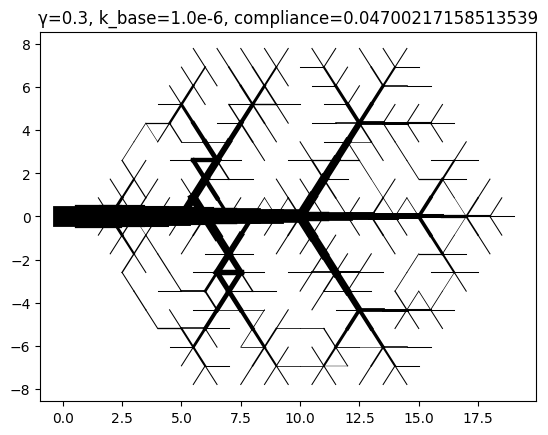

PyObject Text(0.5, 1.0, 'γ=0.3, k_base=1.0e-6, compliance=0.04700217158513539')

In [12]:
res = load_single("results/leaf/size_19/results_423222098_1.bson", "423222098")

fig, ax = subplots()

plot_network_2d!(ax, res[:den].netw, res[:k_min]; γ=0.25)
ax.set_title("γ=$(res[:result][:γ]), k_base=$(res[:result][:k_base]), compliance=$(res[:result][:compliance])")

In [12]:
# uniform leaf-like network
den = result_05[:den]
γ = result_05[:result][:γ]
k_unif = ones(den.netw.N_e)
k_unif = k_unif./(sum(k_unif.^γ)/den.netw.N_e).^(1/γ)

k0 = result_05[:k0]

y_u, g_u = solve_gravity(den, k_unif .+ k0)
u_unif = reshape(den.Φ*y_u, den.netw.N_v, 3)

local_compliance_unif = sum(reshape((den.Φ*y_u).*(den.Φ*g_u), den.netw.N_v, 3), dims=2);

y_u'*g_u

83.06003763962026

# Fig 2: Leaf networks

In [13]:
journal_style = :paren

function fl(s)
    if journal_style == :paren
        "("*lowercase(s)*")"
    elseif journal_style == :PNAS
        uppercase(s)
    end
end

fl (generic function with 1 method)

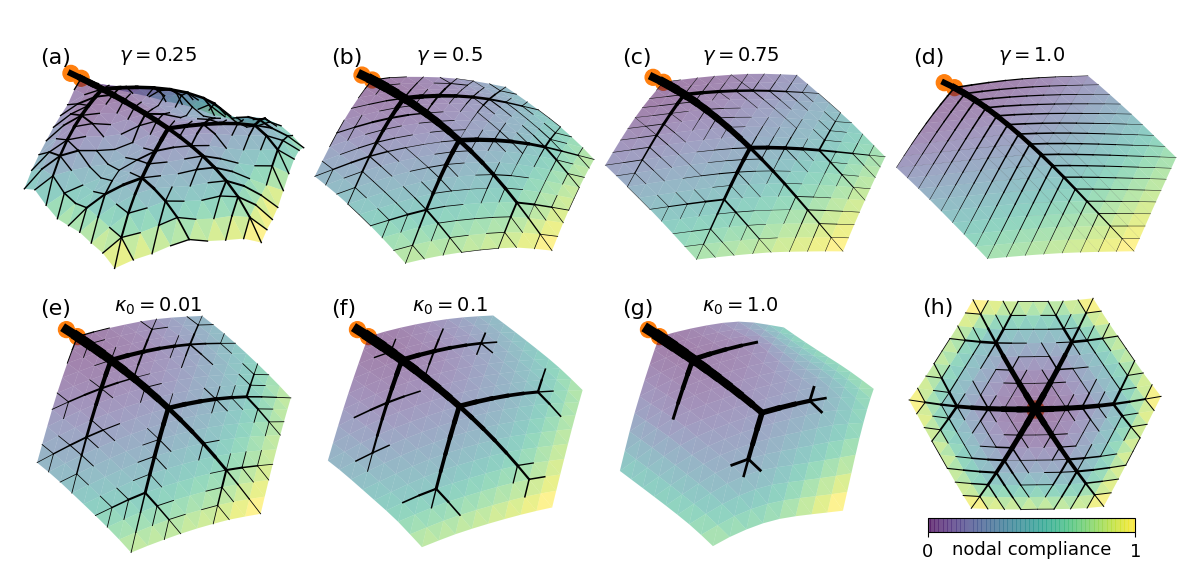

In [17]:
fig = figure(figsize=(12, 6))

Ne = den.netw.N_e
#########
ax = fig.add_subplot(241, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_025[:k_min]), result_025[:u]; 
    c=1000result_025[:local_fu]/Ne^0.25, γ=0.125, normalize_colors=true, vlimits=(0.0, 1.0))
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-0.055, 0.025)
ax.dist = 6.2

ax.axis("off")
ax.set_title(fl("A"), loc="left", fontsize=16, y=0.79, x=0.1)

ax.set_title(L"$\gamma=0.25$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(242, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_05[:k_min]), result_05[:u]; 
    c=1000result_05[:local_fu]/Ne^0.5, γ=0.25, normalize_colors=true, vlimits=(0.0, 1.0))
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-1.9, 0.9)
ax.dist = 6.2

ax.axis("off")
ax.set_title(fl("B"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\gamma=0.5$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(243, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_075[:k_min]), result_075[:u]; 
    c=1000result_075[:local_fu]/Ne^0.75, γ=0.325, normalize_colors=true, vlimits=(0.0, 1.0))
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-11, 5.5)
ax.dist = 6.2

ax.axis("off")
ax.set_title(fl("C"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\gamma=0.75$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(244, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_10[:k_min]), result_10[:u]; 
    c=1000result_10[:local_fu]/Ne, γ=0.35, normalize_colors=true, vlimits=(0.0, 1.0))
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-30, 17)
ax.dist = 6.2

ax.axis("off")
ax.set_title(fl("D"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\gamma=1.0$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(245, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_1em2[:k_min]), result_1em2[:u]; 
    c=1000result_1em2[:local_fu]/Ne, γ=0.25, normalize_colors=true, vlimits=(0.0, 1.0),
    viewx=50, viewy=-50)
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-1.5, 1.)
ax.dist = 6.5

ax.axis("off")
ax.set_title(fl("E"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\kappa_0=0.01$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(246, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_1em1[:k_min]), result_1em1[:u]; 
    c=1000result_1em1[:local_fu]/Ne, γ=0.25, normalize_colors=true, vlimits=(0.0, 1.0),
    viewx=50, viewy=-50)
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-1.5, 1.)
ax.dist = 6.5

ax.axis("off")
ax.set_title(fl("F"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\kappa_0=0.1$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)

#########
ax = fig.add_subplot(247, projection="3d")

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_1em0[:k_min]), result_1em0[:u]; 
    c=1000result_1em0[:local_fu]/Ne, γ=0.25, normalize_colors=true, vlimits=(0.0, 1.0),
    viewx=50, viewy=-50)
# fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15)

# fixed indices
plot_fixed_idx!(ax, den; s=130)

ax.set_zlim(-1.5, 1.)
ax.dist = 6.5

ax.axis("off")
ax.set_title(fl("G"), loc="left", fontsize=16, y=0.79, x=0.1)
ax.set_title(L"$\kappa_0=1.0$", loc="center", fontsize=14, y=0.87)

ax.patch.set_alpha(0.0)


#########
ax = fig.add_subplot(248, projection="3d")

sc, es = plot_network_3d!(ax, lilypad_05[:den].netw, filter_k(lilypad_05[:k_min]), -2lilypad_05[:u]; 
    c=100000lilypad_05[:local_fu]/Ne, γ=0.25, viewx=55, viewy=89, normalize_colors=true, vlimits=(0.0, 1.0))
cb = fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.7, aspect=15, ticks=[0.0, 1.0],
    orientation="horizontal", pad=-0.02)
cb.set_label("nodal compliance", labelpad=-14, fontsize=13)
cb.ax.tick_params(labelsize=13)

# fixed indices
plot_fixed_idx!(ax, lilypad_05[:den]; idx=[9], s=150)

ax.set_zlim(-0.9, 2.2)
ax.dist = 6

ax.axis("off")
ax.set_title(fl("H"), loc="left", fontsize=16, y=0.745, x=0.1)
# ax.set_title("γ=0.5", loc="center", fontsize=14, y=0.85)

ax.patch.set_alpha(0.0)


fig.tight_layout()
fig.subplots_adjust(wspace=-0.02, hspace=-0.2)

fig.savefig("../figures/figure_2.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figures/figure_2.svg", dpi=300, bbox_inches="tight")

# Fig 3: Phase transition

In [11]:
results_path = "results/leaf/size_11"

# list available data sets

networks = Glob.glob(joinpath(results_path, "network_*.bson"))
network_ids = [basename(n)[9:end-5] for n in networks]

df_11 = vcat([load_results(size, id; thr_std=1e-8, only_converged=false) for id in network_ids for size in [11]]...);

(network_id, nrow(df), nrow(df_converged)) = ("1258867976", 3125, 3125)
(network_id, nrow(df), nrow(df_converged)) = ("1438677133", 12, 12)
(network_id, nrow(df), nrow(df_converged)) = ("1822848138", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("476258089", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("722962472", 3125, 3125)


In [12]:
kbase = 10.0.^LinRange(-6, 0.5, 25)
gamma = LinRange(0.2, 1.1, 25)

Nn, Nm = length(kbase), length(gamma)

(25, 25)

In [13]:
loop_mat = zeros(Nn, Nm)

compliance_mat = zeros(Nn, Nm)
sigma_mat = zeros(Nn, Nm)
edges_mat = zeros(Nn, Nm)

# df_by = by(df_results, [:size, :γ, :k_base], [:compliance => mean, :compliance => std])
df_by = by(df_11, [:size, :γ, :k_base], [:loops => mean, :loops => std, :compliance => mean, 
        :compliance => std, :sigma_k => mean, :sigma_k => std, :edges => mean])


for j=1:Nn
    for i=1:Nm
        cu = uniform_compliance(den, kbase[i], gamma[j])
        
        df_f = filter(r -> ((r[:k_base] == kbase[i]) & (r[:γ] == gamma[j])), df_by)
        
        if length(df_f.loops_mean) > 0
            loop_mat[j,i] = df_f.loops_mean[1]
        else
            loop_mat[j,i] = NaN
        end
        
        if length(df_f.compliance_mean) > 0
            compliance_mat[j,i] = df_f.compliance_mean[1]./cu
        else
            compliance_mat[j,i] = NaN
        end
        
        if length(df_f.sigma_k_mean) > 0
            sigma_mat[j,i] = df_f.sigma_k_mean[1]
        else
            sigma_mat[j,i] = NaN
        end
        
        if length(df_f.edges_mean) > 0
            edges_mat[j,i] = df_f.edges_mean[1]
        else
            edges_mat[j,i] = NaN
        end
    end
end

In [14]:
meshgrid(x, y) = repeat(x', length(y)), collect(repeat(y', length(x))')

lk = log10.(kbase)

# attach one more data point
delta = lk[end] - lk[end-1]
kbase_edges = 10.0.^(vcat(lk, [lk[end] + delta]) .- delta/2)

delta = gamma[end] - gamma[end-1]
gamma_edges = vcat(gamma, [gamma[end] + delta]) .- delta/2

# edges for pcolormesh
X, Y = meshgrid(kbase_edges, gamma_edges)

# centers for contour
zoom = pyimport("scipy.ndimage").zoom
gaussian_filter = pyimport("scipy.ndimage.filters").gaussian_filter

zoom_f = 3
kbase_z = 10.0.^LinRange(-6, 0.5, zoom_f*25)
gamma_z = LinRange(0.2, 1.1, zoom_f*25)
Xc, Yc = meshgrid(kbase_z, gamma_z)

# retain zeros in the zoomed and smoothened version
loops_zeros = copy(loop_mat)
loops_zeros[isnan.(loops_zeros)] .= 0.0
loops_z = gaussian_filter(zoom(loops_zeros, zoom_f, mode="mirror"), 3);
loops_zu = gaussian_filter(zoom(loops_zeros, zoom_f, mode="mirror"), 2);

In [15]:
result_A = load_single("results/leaf/size_11/results_1258867976_1011.bson", "1258867976")
result_B = load_single("results/leaf/size_11/results_1258867976_2582.bson", "1258867976")
result_C = load_single("results/leaf/size_11/results_1258867976_1620.bson", "1258867976")

Dict{Any,Any} with 7 entries:
  :result    => Dict{Symbol,Any}(:γ=>1.0625,:N=>11,:converged=>true,:iterations…
  :den       => DiscreteElasticNetwork(MechanicalNetwork(241, 92, Any[[4, 16], …
  :local_fu  => [0.0; 0.0; … ; 0.0711355; 0.0707543]
  0.00177828 => 0.00177828
  :k_min     => [3.89967e-5, 0.0351245, 0.717573, 0.297719, 0.06378, 0.20524, 0…
  :k0        => [1.99704, 0.558402, 0.183516, 0.600686, 1.48993, 1.88114, 1.483…
  :u         => [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 -6.54447; 0.0 0.0 -6.509…

In [16]:
den = result_A[:den]
γ = 0.5
k_unif = ones(den.netw.N_e)
k_unif = k_unif./(sum(k_unif.^γ)/den.netw.N_e).^(1/γ)

y_u, g_u = solve_gravity(den, k_unif .+ 4)
u_unif = reshape(den.Φ*y_u, den.netw.N_v, 3)

local_compliance_unif = sum(reshape((den.Φ*y_u).*(den.Φ*g_u), den.netw.N_v, 3), dims=2);

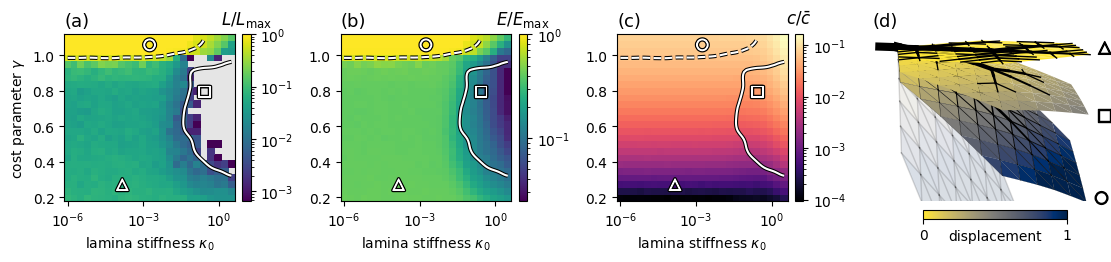

In [19]:
# fig, axs = subplots(1, 3, figsize=(9, 2.7))
fig = figure(figsize=(11, 2.7))

LogNorm = pyimport("matplotlib.colors").LogNorm
pe = pyimport("matplotlib.patheffects")

ax = fig.add_subplot(141)
ax.set_facecolor([0.5, 0.5, 0.5, 0.2])

sc = ax.pcolormesh(X, Y, loop_mat./maximum(loop_mat[.!isnan.(loop_mat)]), norm=LogNorm(), rasterized=true,
    cmap="viridis")
cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_title(L"$L/L_{\mathrm{max}}$", y=1.01)


cnt = ax.contour(Xc, Yc, loops_z, [0.9], colors="w")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end

cnt = ax.contour(Xc, Yc, loops_zu, [0.6maximum(loops_zu)], colors="w", linestyles="--")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end


ax.text(result_A[:result][:k_base], result_A[:result][:γ], "△", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_B[:result][:k_base], result_B[:result][:γ], "□", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_C[:result][:k_base], result_C[:result][:γ], "○", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])


ax.set_xscale("log")

ax.set_xticks([1e-6, 1e-3, 1e0])

ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"cost parameter $\gamma$")
ax.set_title(fl("A"), loc="left", fontsize=13)


ax = fig.add_subplot(142)
sc = ax.pcolormesh(X, Y, edges_mat./maximum(edges_mat), norm=LogNorm(),
    cmap="viridis", rasterized=true)#, vmax = 5.2)

cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)#, ticks=[1, 2, 3, 4, 5])
cb.ax.set_title(L"$E/E_\mathrm{max}$", y=1.01)


cnt = ax.contour(Xc, Yc, loops_z, [0.9], colors="w")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end

cnt = ax.contour(Xc, Yc, loops_zu, [0.6maximum(loops_zu)], colors="w", linestyles="--")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end


ax.text(result_A[:result][:k_base], result_A[:result][:γ], "△", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_B[:result][:k_base], result_B[:result][:γ], "□", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_C[:result][:k_base], result_C[:result][:γ], "○", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])

# ax.set_aspect(6.5)
ax.set_xscale("log")

ax.set_xticks([1e-6, 1e-3, 1e0])

ax.set_xlabel(L"lamina stiffness $\kappa_0$")
# ax.set_ylabel(L"cost parameter $\gamma$")
ax.set_title(fl("B"), loc="left", fontsize=13)


ax = fig.add_subplot(143)
# sc = ax.imshow(log10.(compliance_mat), extent=[log10(kbase[1]), log10(kbase[end]), gamma[1], gamma[end]], 
#     origin="lower", cmap="magma")
sc = ax.pcolormesh(X, Y, compliance_mat, norm=LogNorm(), cmap="magma", rasterized=true)

cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_title(L"$c/\bar{c}$", y=1.01)


cnt = ax.contour(Xc, Yc, loops_z, [0.9], colors="w")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end

cnt = ax.contour(Xc, Yc, loops_zu, [0.6maximum(loops_zu)], colors="w", linestyles="--")
for c in cnt.collections
    c.set_path_effects([pe.Stroke(linewidth=3, foreground="black"),
                       pe.Normal()])
end


ax.text(result_A[:result][:k_base], result_A[:result][:γ], "△", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_B[:result][:k_base], result_B[:result][:γ], "□", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])
ax.text(result_C[:result][:k_base], result_C[:result][:γ], "○", color="w", fontweight="bold",
    horizontalalignment="center", verticalalignment="center",
    fontsize=11, path_effects=[pe.Stroke(linewidth=2.5, foreground="black"), pe.Stroke(linewidth=.75)])


ax.set_xscale("log")

ax.set_xticks([1e-6, 1e-3, 1e0])

ax.set_xlabel(L"lamina stiffness $\kappa_0$")
# ax.set_ylabel(L"cost parameter $\gamma$")
ax.set_title(fl("C"), loc="left", fontsize=13)


ax = fig.add_subplot(144, projection="3d")
ax.force_zorder = true

ax.set_title(fl("D"), loc="left", x=0.07, fontsize=13)
ax.force_zorder = true

leaf_cmap = "cividis_r"
sc, es = plot_network_3d!(ax, den.netw, filter_k(k_unif), u_unif; 
    c=12.5local_compliance_unif, γ=0.5/2, normalize_colors=false, vlimits=(0.0, 1), alpha=0.15, alpha_surf=0.15,
    zorder_surf=-Inf, zorder_netw=-Inf, cmap=leaf_cmap)

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_C[:k_min]), result_C[:u]; 
    c=12.5result_C[:local_fu], γ=1.025/2, normalize_colors=false, vlimits=(0.0, 1), alpha=1.0, alpha_surf=1,
    zorder_surf=-5000, zorder_netw=-1000, cmap=leaf_cmap)

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_B[:k_min]), result_B[:u]; 
    c=12.5result_B[:local_fu], γ=0.65/2, normalize_colors=false, vlimits=(0.0, 1), alpha=1.0, alpha_surf=1,
    zorder_surf=0, zorder_netw=400, cmap=leaf_cmap)

sc, es = plot_network_3d!(ax, den.netw, filter_k(result_A[:k_min]), result_A[:u]; 
    c=12.5result_A[:local_fu], γ=0.275/2, normalize_colors=false, vlimits=(0.0, 1), alpha=1.0, alpha_surf=1,
    zorder_surf=1000, zorder_netw=2000, cmap=leaf_cmap,
    viewx=12, viewy=-70)

cb = fig.colorbar(sc, ax=ax, label="nodal compliance", shrink=0.8, aspect=15,
    orientation="horizontal", pad=0.05, ticks=[0.0, 1.0])
cb.set_label("displacement", labelpad=-10)

ax.set_zlim(-9.2, 1)
ax.text(11.4, 0, 0.1, "△", fontsize=12, fontweight="bold", path_effects=[pe.Stroke(linewidth=1)])
ax.text(11.4, 0, -4, "□", fontsize=12, fontweight="bold", path_effects=[pe.Stroke(linewidth=1)])
ax.text(11.4, 0, -9.2, "○", fontsize=12, fontweight="bold", path_effects=[pe.Stroke(linewidth=1)])

ax.axis("off")
ax.dist = 5.5
ax.patch.set_alpha(0.0)

fig.tight_layout()

# move 3d plot to the left
box = ax.get_position()
box.x0 = box.x0 - 0.035
box.x1 = box.x1 + 0.02
box.y0 = box.y0 - 0.125
ax.set_position(box)

# move colorbar to the left
box = cb.ax.get_position()
box.x0 = box.x0 + 0.01
box.x1 = box.x1 + 0.005
box.y0 = box.y0 - 0.125
box.y1 = box.y1 - 0.125

cb.ax.set_position(box)

fig.savefig("../figures/figure_3.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figures/figure_3.svg", dpi=300, bbox_inches="tight")

In [39]:
γs = unique(df_11.γ)
k_bases = unique(df_11.k_base)

for group in groupby(df_11, [:size, :γ, :k_base])
    if (group[!,:k_base][1] != 0.26101572156825387) | (group[!,:γ][1] != 0.8)
        continue
    end
    
    println("N = $(group[!,:size][1]), γ = $(group[!,:γ][1]), k_base = $(group[!,:k_base][1])")
    best_network_idx = argmin(group[!,:compliance])
    best_network_fname = group[!,:filename][best_network_idx]
    
    println("compliance = $(group[!,:compliance][best_network_idx])")
    println("$(best_network_fname), N_therm = $(group[!,:anneal][best_network_idx])")
end

N = 11, γ = 0.8, k_base = 0.26101572156825387
compliance = 1.7603734678218685
results/leaf/size_11/results_1258867976_2582.bson, N_therm = 30


In [40]:
kbase

25-element Array{Float64,1}:
 1.0e-6
 1.865663578576911e-6
 3.480700588428413e-6
 6.493816315762113e-6
 1.2115276586285876e-5
 2.2603030271419218e-5
 4.216965034285822e-5
 7.867438076599394e-5
 0.0001467799267622069
 0.0002738419634264361
 0.0005108969774506935
 0.0009531618832347863
 0.0017782794100389228
 0.003317671127842858
 0.006189658188912603
 0.011547819846894581
 0.021544346900318832
 0.04019450333615128
 0.07498942093324558
 0.13990503141372929
 0.26101572156825387
 0.4869675251658631
 0.9085175756516863
 1.6949881513903475
 3.1622776601683795

In [41]:
gamma |> collect

25-element Array{Float64,1}:
 0.2
 0.23750000000000002
 0.275
 0.3125
 0.35000000000000003
 0.3875
 0.42500000000000004
 0.4625
 0.5
 0.5375000000000001
 0.5750000000000001
 0.6125
 0.65
 0.6875
 0.7250000000000001
 0.7625
 0.8
 0.8375000000000001
 0.8750000000000001
 0.9125
 0.9500000000000001
 0.9875000000000002
 1.025
 1.0625
 1.1

# Supplemental Figure 1: Scaling of the topological space

In [10]:
results_path = "results/leaf/size_*"

# list available data sets

networks = Glob.glob(joinpath(results_path, "network_*.bson"))
network_ids = [basename(n)[9:end-5] for n in networks]

df_as = vcat([df for df in [load_results(size, id; thr_std=1e-8, only_converged=false) 
                for id in network_ids for size in [11, 13, 15, 17, 19]]
                if nrow(df) > 0]...);

df_as = filter(r -> r[:anneal] == 30, df_as);

(network_id, nrow(df), nrow(df_converged)) = ("1258867976", 3125, 3125)
(network_id, nrow(df), nrow(df_converged)) = ("1438677133", 12, 12)
(network_id, nrow(df), nrow(df_converged)) = ("1822848138", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("476258089", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("722962472", 3125, 3125)
(network_id, nrow(df), nrow(df_converged)) = ("1125126464", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("1143256347", 320, 320)
(network_id, nrow(df), nrow(df_converged)) = ("411073898", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("862535277", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("1233795133", 238, 238)
(network_id, nrow(df), nrow(df_converged)) = ("1414160736", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("1415225545", 229, 229)
(network_id, nrow(df), nrow(df_converged)) = ("1442430133", 250, 250)
(network_id, nrow(df), nrow(df_converged)) = ("1679710467", 320, 320)
(network_id, nrow(df),

In [11]:
df_by = by(df_as, [:size, :γ, :k_base], [:loops => mean, :loops => std, :edges => mean, :edges => std,
        :compliance => mean, :compliance => std]);

sizes = sort(unique(df_by.size))
kbases = 10.0.^LinRange(-6, 0.5, 25)
gammas = LinRange(0.2, 1.1, 25)

df_filtered_gamma = [filter(r -> (r[:size] == s) & (r[:γ] == 0.5) & (r[:k_base] in kbases), df_by) for s in sizes];

for df in df_filtered_gamma
    sort!(df, [:k_base])
end

df_filtered_kb = [filter(r -> (r[:size] == s) & (r[:k_base] == 1e-3) & (r[:γ] in gammas), df_by) for s in sizes];

for df in df_filtered_kb
    sort!(df, [:γ])
end

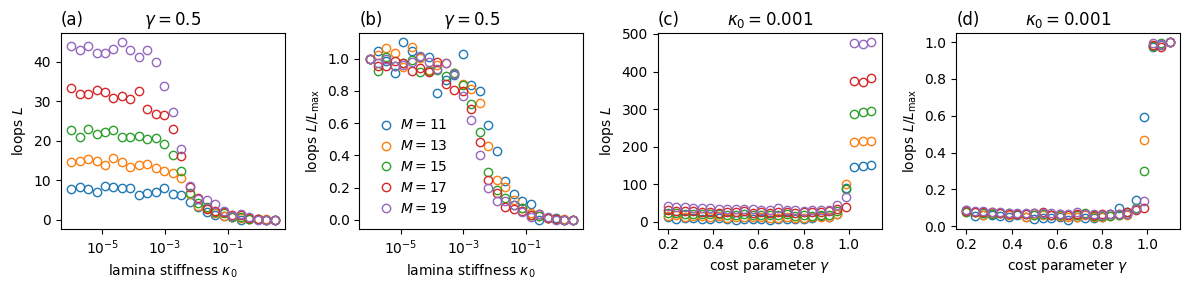

In [12]:
fig, axs = subplots(1, 4, figsize=(12, 3))

ax = axs[1]

for (s, df) in zip(sizes, df_filtered_gamma)
    ax.errorbar(df.k_base, df.loops_mean, fmt="o", markerfacecolor="none",
        #yerr=df.loops_std, 
        label="\$M=$(s)\$")
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"loops $L$")
ax.set_title("(a)", loc="left")
ax.set_title(L"$\gamma = 0.5$")


ax = axs[2]

for (s, df) in zip(sizes, df_filtered_gamma)
    ax.errorbar(df.k_base, df.loops_mean./df.loops_mean[1], 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none", label="\$M=$(s)\$"
    )
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"loops $L/L_\mathrm{max}$")
ax.set_title("(b)", loc="left")
ax.set_title(L"$\gamma = 0.5$")

ax.legend(frameon=false, handletextpad=0.01)

ax = axs[3]

for (s, df) in zip(sizes, df_filtered_kb)
    ax.errorbar(df.γ, df.loops_mean,
#         yerr=df.loops_std,
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"loops $L$")
ax.set_title("(c)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")

ax = axs[4]

for (s, df) in zip(sizes, df_filtered_kb)
    ax.errorbar(df.γ, df.loops_mean./df.loops_mean[end], 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"loops $L/L_\mathrm{max}$")
ax.set_title("(d)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")


fig.tight_layout()
fig.savefig("../figures/supp_figure_loops.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figures/supp_figure_loops.svg", dpi=300, bbox_inches="tight")

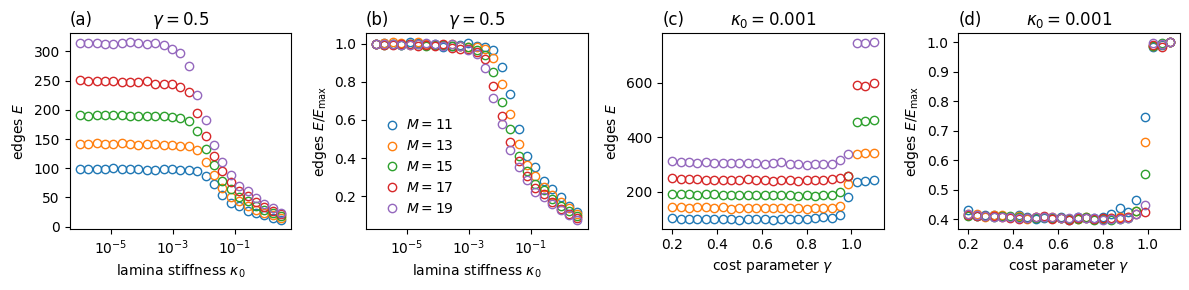

In [13]:
fig, axs = subplots(1, 4, figsize=(12, 3))

ax = axs[1]

for (s, df) in zip(sizes, df_filtered_gamma)
    ax.errorbar(df.k_base, df.edges_mean, fmt="o", markerfacecolor="none",
        #yerr=df.loops_std, 
        label="\$M=$(s)\$")
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"edges $E$")
ax.set_title("(a)", loc="left")
ax.set_title(L"$\gamma = 0.5$")


ax = axs[2]

for (s, df) in zip(sizes, df_filtered_gamma)
    ax.errorbar(df.k_base, df.edges_mean./df.edges_mean[1], 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none", label="\$M=$(s)\$"
    )
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"edges $E/E_\mathrm{max}$")
ax.set_title("(b)", loc="left")
ax.set_title(L"$\gamma = 0.5$")

ax.legend(frameon=false, handletextpad=0.01)

ax = axs[3]

for (s, df) in zip(sizes, df_filtered_kb)
    ax.errorbar(df.γ, df.edges_mean,
#         yerr=df.loops_std,
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"edges $E$")
ax.set_title("(c)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")

ax = axs[4]

for (s, df) in zip(sizes, df_filtered_kb)
    ax.errorbar(df.γ, df.edges_mean./df.edges_mean[end], 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"edges $E/E_\mathrm{max}$")
ax.set_title("(d)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")


fig.tight_layout()
fig.savefig("../figures/supp_figure_edges.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figures/supp_figure_edges.svg", dpi=300, bbox_inches="tight")

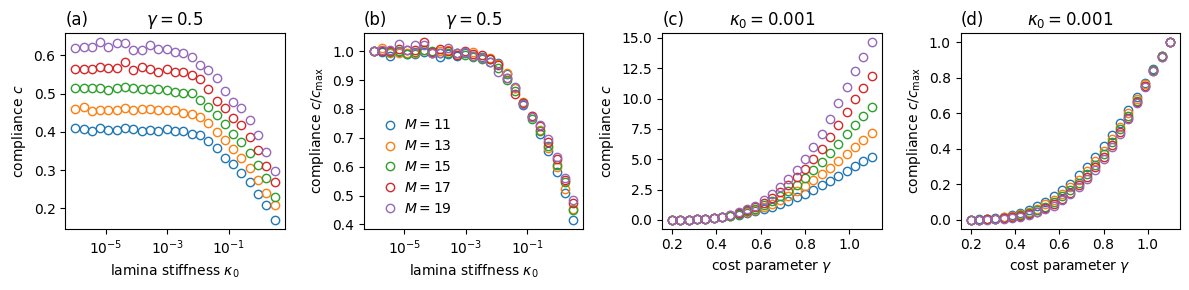

In [14]:
fig, axs = subplots(1, 4, figsize=(12, 3))

ax = axs[1]


# ccus_gamma = []
for (s, df) in zip(sizes, df_filtered_gamma)
        # compute uniform compliance equivalents
#     nw = filter(r -> r[:size] == s, df_as).network_id[1]
#     den = BSON.load(nw)[:network]
    
#     c_uniform = [uniform_compliance(den, kb, 0.5) for kb in df.k_base]
#     ccu = df.compliance_mean./c_uniform
    
#     push!(ccus_gamma, ccu)
    
    ax.errorbar(df.k_base, df.compliance_mean, fmt="o", markerfacecolor="none",
        #yerr=df.loops_std, 
        label="\$M=$(s)\$")
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"compliance $c$")
ax.set_title("(a)", loc="left")
ax.set_title(L"$\gamma = 0.5$")


ax = axs[2]

for (s, df) in zip(sizes, df_filtered_gamma)
    ax.errorbar(df.k_base, df.compliance_mean./df.compliance_mean[1], 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none", label="\$M=$(s)\$"
    )
end
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"lamina stiffness $\kappa_0$")
ax.set_ylabel(L"compliance $c/c_\mathrm{max}$")
ax.set_title("(b)", loc="left")
ax.set_title(L"$\gamma = 0.5$")

ax.legend(frameon=false, handletextpad=0.01)


ax = axs[3]
# ccus_kappa = []

for (s, df) in zip(sizes, df_filtered_kb)
#         # compute uniform compliance equivalents
#     nw = filter(r -> r[:size] == s, df_as).network_id[1]
#     den = BSON.load(nw)[:network]
    
#     c_uniform = [uniform_compliance(den, 1e-3, gamma) for gamma in df.γ]
#     ccu = df.compliance_mean./c_uniform
    
#     push!(ccus_kappa, ccu)
    
    ax.errorbar(df.γ, df.compliance_mean,
#         yerr=df.loops_std,
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"compliance $c$")
ax.set_title("(c)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")

ax = axs[4]

for (s, df) in zip(sizes, df_filtered_kb)
    # TODO: WAIT UNTIL THIS IS DONE COMPUTING AND THEN CHECK SCALING
    ax.errorbar(df.γ, df.compliance_mean./maximum(df.compliance_mean), 
#         yerr=df.loops_std./maximum(df.loops_mean),
        fmt="o", markerfacecolor="none",
    )
end
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(L"cost parameter $\gamma$")
ax.set_ylabel(L"compliance $c/c_\mathrm{max}$")
ax.set_title("(d)", loc="left")
ax.set_title(L"$\kappa_0 = 0.001$")


fig.tight_layout()
fig.savefig("../figures/supp_figure_compliance.pdf", dpi=300, bbox_inches="tight")
fig.savefig("../figures/supp_figure_compliance.svg", dpi=300, bbox_inches="tight")